1. Apache Spark

Как я понимаю его после нескольких часов статей и видео:
Ультимативный инструмент для инженера для работы с графовыми алгоритмами, машинным обучением, обработки и анализа данных.
Это движок и набор библиотек, основное приемущество это структура набора данных, которая делится на части в нодах  кластеров, что значительно упрощает и ускоряет работу с данными, особенно с большими, тк при стандартном использовании языков программирования мы ограничены оперативной памятью компьютера.
Поддерживает множество языков для работы.
Разные источники описыват разные приемущества, кто-то полностью работает на спарк, кто-то рекомендует использовать его частично для различных операций. Но это предстоит проверить дальше лично.

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize' : (16,6)}, style="whitegrid")

In [2]:
table = pd.read_parquet('/Users/dmyakovlev/Desktop/fcst.parquet',)

In [3]:
table.head()

,id,time_period,sales,fcst1,fcst2,fcst3,fcst4
0,0,1,743.0,5316.803341,5978.720782,4267.971145,4283.282927
1,1,1,2851.0,2984.880237,2591.821366,2650.744227,2505.751384
2,2,1,2183.0,2580.991286,3030.257809,2762.233600,2722.675689
3,3,1,1867.0,816.092797,159.134282,1162.324517,908.373377
4,4,1,3442.0,3898.294959,3280.919560,3636.127401,3752.789970


Изучим данные

In [4]:
table.shape

(930, 7)

In [5]:
table.dtypes

id               int64
time_period      int64
sales          float64
fcst1          float64
fcst2          float64
fcst3          float64
fcst4          float64
dtype: object

In [6]:
table.describe()

,id,time_period,sales,fcst1,fcst2,fcst3,fcst4
count,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000
mean,58.306452,4.534409,5835.806452,4576.589131,5163.660530,4641.841656,4013.288654
std,33.877123,2.289913,11802.887836,9333.606705,8633.606995,9882.923464,7303.040683
min,0.000000,1.000000,1.000000,47.578076,-598.811065,-180.897304,-33.547054
25%,29.000000,3.000000,758.000000,608.830656,1661.954150,777.115580,412.589021
50%,58.500000,5.000000,2053.500000,1807.898673,2782.451917,1844.123203,1426.920042
75%,87.750000,7.000000,5466.750000,4883.102332,4960.071922,4387.844722,4279.336002
max,120.000000,8.000000,128950.000000,135445.001194,112443.508856,139351.046333,66383.716284


Пропущенных значений и нулей нет, айдишники и временные метки преобразований не требуют

У трех моделей наблюдаем отрицательные значения, проверим насколько много таких выбросов

In [7]:
table[table.fcst2 < 0]

,id,time_period,sales,fcst1,fcst2,fcst3,fcst4
267,3,3,629.0,1217.393804,-598.811065,1638.073896,1368.579021
322,56,3,256.0,324.814822,-12.078556,222.245280,233.006340
427,3,4,596.0,918.979979,-346.044486,1223.218830,906.262423
522,3,5,392.0,892.902306,-384.462354,1283.148247,1029.801734
654,3,6,463.0,1306.697973,-381.796940,1700.005139,1407.558994
799,3,7,320.0,883.999918,-335.031317,1309.236461,1012.855068
871,3,8,2280.0,883.176212,-368.238770,1323.570857,1090.849136


In [8]:
table[table.fcst3 < 0]

,id,time_period,sales,fcst1,fcst2,fcst3,fcst4
229,70,3,329.0,271.582036,1300.009588,-7.130992,49.920105
318,41,3,457.0,468.783149,2114.621573,-13.766030,42.884493
348,47,4,1.0,63.018438,482.180784,-180.897304,6.795815


In [9]:
table[table.fcst4 < 0]

,id,time_period,sales,fcst1,fcst2,fcst3,fcst4
98,98,1,13301.0,3730.953238,5452.613747,2961.530749,-33.547054
363,52,4,3.0,102.025875,691.090831,109.709187,-5.788873
372,41,4,9.0,230.031687,1430.217227,194.693049,-3.308518
404,63,4,8.0,343.050336,2135.980704,292.470357,-7.679724
421,61,4,2077.0,402.188841,1684.626236,597.121376,-0.049494
605,28,6,2031.0,573.853964,1639.232357,175.931620,-13.174704


Видим, что больше таких значений у второй модели, но в целом, погрешность меньше 1 процента. 

У второй модели почти все минусы связаны с товаром с id 3 ( в 6-и из 8-ми временных периодов модель этот товар посчитала в ноль). У четвертой выбросы чаще связаны с 4-ым периодом. 

Посмотрим, как данные о продажах выглядят на графике

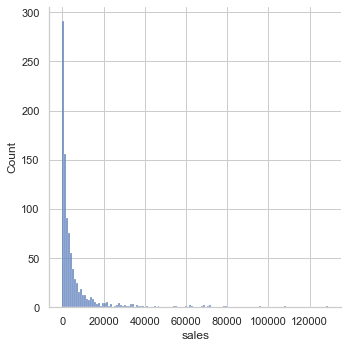

In [10]:
sns.displot(table.sales, kde=False)

Видим, что наибольшее количество приходится на показатели продаж до 5000. Плавно уменьшается до 20000 и после этого значения показатели встречаются редко. Поделим наши данные на три группы по продажам, чтобы проверить насколько хорошо разные прогнозы справляются с разными показателями.

1 - до 5000; 2 - от 5000 до 20000; 3 - более 20000

Так же посмотрим на самые продаваемые товары, чтобы посмотреть, как метрики справляются с бестселлерами

In [12]:
table.groupby('id', as_index=False).agg({'sales' : 'sum'}) \
    .sort_values('sales', ascending=False) \
    .head()

,id,sales
79,79,684320.0
77,77,324014.0
85,85,298491.0
117,117,276159.0
64,64,238596.0


Сделаем три таблицы с диапазонами продаж

In [13]:
table1 = table[table.sales < 5000]

In [14]:
table2 = table.loc[(table.sales > 5000) & (table.sales < 20000), :]

In [15]:
table3 = table[table.sales > 20000]

Посчитаем MAPE каждого прогноза для общих данных, для каждого из трех диапазонов продаж и для бестселлеров

In [16]:
def MAPE(true: np.array, pred: np.array, acceptable_error:float=0.4) -> float:
    vector_of_errors = np.where(true == 0,
                                    0,

                                    np.where(np.abs(true - pred) >
    true*acceptable_error,
                                     0, 
                                     1 
                                    )
                            )
    return np.sum(vector_of_errors) / len(vector_of_errors)

Для общих данных

* Далее будет большое количество строчек подсчетов, я хотел просто вставить данные из черновика, но решил, что будет лучше, если ты будешь видеть все подсчеты, во избежание или обнаружение ошибок. Так же, наверняка, можно сделать все эти подсчеты более аккуратно и компактно, буду рад, если покажешь как

In [17]:
true = table.sales
pred = table.fcst1

In [18]:
MAPE(true, pred)

0.5268817204301075

In [19]:
true = table.sales
pred = table.fcst2

In [20]:
MAPE(true, pred)

0.4290322580645161

In [21]:
true = table.sales
pred = table.fcst3

In [22]:
MAPE(true, pred)

0.5118279569892473

In [23]:
true = table.sales
pred = table.fcst4

In [24]:
MAPE(true, pred)

0.4505376344086022

Для продаж до 5000

In [25]:
true = table1.sales
pred = table1.fcst1

In [26]:
MAPE(true, pred)

0.5051546391752577

In [29]:
true = table1.sales
pred = table1.fcst2

In [30]:
MAPE(true, pred)

0.36229749631811486

In [31]:
true = table1.sales
pred = table1.fcst3

In [32]:
MAPE(true, pred)

0.5066273932253313

In [33]:
true = table1.sales
pred = table1.fcst4

In [34]:
MAPE(true, pred)

0.43888070692194403

Для продаж от 5 до 20000

In [35]:
true = table2.sales
pred = table2.fcst1

In [36]:
MAPE(true, pred)

0.6666666666666666

In [37]:
true = table2.sales
pred = table2.fcst2

In [38]:
MAPE(true, pred)

0.6825396825396826

In [39]:
true = table2.sales
pred = table2.fcst3

In [40]:
MAPE(true, pred)

0.5714285714285714

In [41]:
true = table2.sales
pred = table2.fcst4

In [42]:
MAPE(true, pred)

0.5238095238095238

Для продаж свыше 20000

In [43]:
true = table3.sales
pred = table3.fcst1

In [44]:
MAPE(true, pred)

0.3387096774193548

In [45]:
true = table3.sales
pred = table3.fcst2

In [46]:
MAPE(true, pred)

0.3870967741935484

In [47]:
true = table3.sales
pred = table3.fcst3

In [48]:
MAPE(true, pred)

0.3870967741935484

In [49]:
true = table3.sales
pred = table3.fcst4

In [50]:
MAPE(true, pred)

0.3548387096774194

Сделаем таблицы для бестселлеров

In [51]:
table79 = table[table['id'] == 79]

In [52]:
table77 = table[table['id'] == 77]

In [53]:
table85 = table[table['id'] == 85]

In [54]:
table117 = table[table['id'] == 117]

In [55]:
table64 = table[table['id'] == 64]

Посчитаем

In [56]:
true = table79.sales
pred = table79.fcst1

In [57]:
MAPE(true, pred)

0.0

In [58]:
true = table79.sales
pred = table79.fcst2

In [59]:
MAPE(true, pred)

0.0

In [60]:
true = table79.sales
pred = table79.fcst3

In [61]:
MAPE(true, pred)

0.0

In [62]:
true = table79.sales
pred = table79.fcst4

In [63]:
MAPE(true, pred)

0.0

In [64]:
true = table77.sales
pred = table77.fcst1

In [65]:
MAPE(true, pred)

0.5

In [66]:
true = table77.sales
pred = table77.fcst2

In [67]:
MAPE(true, pred)

0.375

In [68]:
true = table77.sales
pred = table77.fcst3

In [69]:
MAPE(true, pred)

0.375

In [70]:
true = table77.sales
pred = table77.fcst4

In [71]:
MAPE(true, pred)

0.375

In [72]:
true = table85.sales
pred = table85.fcst1

In [73]:
MAPE(true, pred)

1.0

In [74]:
true = table85.sales
pred = table85.fcst2

In [75]:
MAPE(true, pred)

1.0

In [76]:
true = table85.sales
pred = table85.fcst3

In [77]:
MAPE(true, pred)

1.0

In [78]:
true = table85.sales
pred = table85.fcst4

In [79]:
MAPE(true, pred)

1.0

In [80]:
true = table117.sales
pred = table117.fcst1

In [81]:
MAPE(true, pred)

0.0

In [82]:
true = table117.sales
pred = table117.fcst2

In [83]:
MAPE(true, pred)

0.5

In [84]:
true = table117.sales
pred = table117.fcst3

In [85]:
MAPE(true, pred)

0.0

In [86]:
true = table117.sales
pred = table117.fcst4

In [87]:
MAPE(true, pred)

1.0

In [88]:
true = table64.sales
pred = table64.fcst1

In [89]:
MAPE(true, pred)

0.375

In [90]:
true = table64.sales
pred = table64.fcst2

In [91]:
MAPE(true, pred)

0.5

In [92]:
true = table64.sales
pred = table64.fcst3

In [94]:
MAPE(true, pred)

0.625

In [95]:
true = table64.sales
pred = table64.fcst4

In [96]:
MAPE(true, pred)

0.125

На основе всех полученных подсчетов MAPE сделал таблицу


In [99]:
table_mape = pd.read_csv('/Users/dmyakovlev/Desktop/MAPE.csv')

In [100]:
table_mape

,table_name,sales,fcst 1,fcst 2,fcst 3,fcst 4
0,table,5427300,0.5,0.4,0.5,0.45
1,table1,1123773,0.5,0.4,0.5,0.40
2,table2,1753853,0.7,0.7,0.6,0.50
3,table3,2549674,0.3,0.4,0.4,0.35
4,id79,684320,0.0,0.0,0.0,0.00
5,id77,324014,0.5,0.4,0.4,0.40
6,id85,298491,1.0,1.0,1.0,1.00
7,id117,276159,0.0,0.5,0.0,1.00
8,id64,238569,0.4,0.5,0.6,0.10


Посчитаем отклонения для общих даных


Недопрогнозы

In [101]:
def percent_under_forecasts(true: np.array, pred: np.array,
acceptable_error:float=0.4) -> float:
    
    under_fcst = np.where(true - pred > true*acceptable_error,
                                   1,
                                   0
                                   )
    return sum(under_fcst) / len(under_fcst)

In [102]:
true = table.sales
pred = table.fcst1

In [103]:
percent_under_forecasts(true, pred)

0.23870967741935484

In [104]:
true = table.sales
pred = table.fcst2

In [105]:
percent_under_forecasts(true, pred)

0.12903225806451613

In [106]:
true = table.sales
pred = table.fcst3

In [107]:
percent_under_forecasts(true, pred)

0.24301075268817204

In [108]:
true = table.sales
pred = table.fcst4

In [109]:
percent_under_forecasts(true, pred)

0.34946236559139787

Перепрогнозы

In [110]:
def percent_over_forecasts(true: np.array, pred: np.array,
acceptable_error:float=0.4) -> float:
    
    over_fcst = np.where(pred - true > true*acceptable_error,
                                   1,
                                   0
                                   )
    return sum(over_fcst) / len(over_fcst)

In [111]:
true = table.sales
pred = table.fcst1

In [112]:
percent_over_forecasts(true, pred)

0.23440860215053763

In [113]:
true = table.sales
pred = table.fcst2

In [114]:
percent_over_forecasts(true, pred)

0.44193548387096776

In [115]:
true = table.sales
pred = table.fcst3

In [116]:
percent_over_forecasts(true, pred)

0.24516129032258063

In [117]:
true = table.sales
pred = table.fcst4

In [118]:
percent_over_forecasts(true, pred)

0.2

На основе полученных данных сделал таблицу

In [119]:
table_forecasts = pd.read_csv('/Users/dmyakovlev/Desktop/forecasts.csv')

In [120]:
table_forecasts

,name,fcst1,fcst2,fcst3,fcst4
0,under,0.2,0.1,0.2,0.3
1,over,0.2,0.4,0.2,0.2
2,total,0.4,0.5,0.4,0.5


In [121]:
table_mape

,table_name,sales,fcst 1,fcst 2,fcst 3,fcst 4
0,table,5427300,0.5,0.4,0.5,0.45
1,table1,1123773,0.5,0.4,0.5,0.40
2,table2,1753853,0.7,0.7,0.6,0.50
3,table3,2549674,0.3,0.4,0.4,0.35
4,id79,684320,0.0,0.0,0.0,0.00
5,id77,324014,0.5,0.4,0.4,0.40
6,id85,298491,1.0,1.0,1.0,1.00
7,id117,276159,0.0,0.5,0.0,1.00
8,id64,238569,0.4,0.5,0.6,0.10


Подведем итоги

После проведенного анализа по суммарным итогам всех анализов и, учитывая отклонения, самым сильным является прогноз fcst2. И хотя он имеет самый высокий показатель перепрогнозов, что может приводить к списаниям позиций, но за счет регулярного нахождения на полках основных позиций мы получим более лояльную аудиторию, что положительно сказывается на продажах.

Самым большим недостатком всех прогнозов является мусорный прогноз самой продаваемой позиции id79, которая занимает 12,6% от всей суммы продаж. Наилучшим вариантом было бы использование комбинаций прогноза fcst1, который лучше работает с небольшими и средними значениями продаж, не имеет нулевых показателей в прогнозах и имеет низкий показатель перепрогнозов и fcst2, который лучше работает с большими значениями продаж и с бестселлерами и имеет низкий показатель недопрогнозов.
